Kasviryhmän luokittelu 
===================

## Data lataus
Lataa vain 10% [otos](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) koko datasta

In [40]:
import pandas as pd
from IPython.display import display, HTML


parcels = pd.read_csv("../peltolohkot.csv", index_col=False).sample(frac=0.1)
codes = pd.read_csv("../kasvikoodit.csv", index_col="code")

print("Lohkodata – koko: ", len(parcels))
display(parcels.head(3))
print("Kasvikoodidata – koko:", len(codes))
display(HTML(codes.head(5).to_html()))

Lohkodata – koko:  106508


,Unnamed: 0,X,Y,fid,VUOSI,KASVULOHKOTUNNUS,KVI_KASVIKOODI,KLE_LAJIKEKOODI,LUOMUVKD_KOODI,SIELAKD_KOODI,PINTAALA,ONKOEKOLOGINENALA,LISATIETO,JATTOPVM,PERPVM,PAIPVM
1036334,1036334,285549.354602,7.004089e+06,1036335,2018,A,1310.0,AP,0,10,45,2,NaN,NaN,NaN,NaN
224774,224774,531873.788545,7.129679e+06,224775,2018,B,6050.0,NaN,0,0,38,2,NaN,NaN,NaN,NaN
783906,783906,574282.950522,7.139258e+06,783907,2018,A,6121.0,NaN,0,0,429,2,NaN,NaN,NaN,NaN


Kasvikoodidata – koko: 54


,name,group
code,,
2120,Rehuherne,2
5120,Punajuurikas ja keltajuurikas,3
9812,Monivuotinen ympäristönurmi,7
6121,"Moniv. kuivaheinä-, säilörehu- ja tuorerehunurmet",7
2200,Härkäpapu,1


## Datan esikäsittely

Muodosta aluksi kasvikoodidatasta sanakirja, jossa kasvikoodi on avaimena ja ryhmä on arvona ([vinkki](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_dict.html)). 

In [42]:
codes_dict = codes.to_dict()['group']
print(codes_dict)

{2120: 2, 5120: 3, 9812: 7, 6121: 7, 2200: 1, 9404: 4, 4210: 5, 1400: 6, 1211: 6, 1120: 6, 1220: 6, 6111: 7, 6112: 7, 6561: 7, 2430: 7, 4110: 9, 2110: 2, 3210: 3, 9403: 4, 1545: 6, 1320: 6, 1310: 6, 4905: 7, 9820: 7, 9811: 7, 9810: 7, 9405: 7, 6125: 7, 6123: 7, 6122: 7, 4904: 7, 6210: 7, 9424: 7, 6220: 7, 9423: 7, 6300: 7, 3160: 8, 3120: 8, 3110: 8, 1230: 10, 5101: 2, 1605: 6, 1602: 6, 1601: 6, 1603: 6, 9805: 7, 6050: 7, 6051: 7, 9412: 7, 3190: 8, 3150: 8, 3130: 8, 1141: 10, 1110: 10}


Sitten luo lohkodataan uusi sarake `group`, ja sijoita siihen aluksi kasvikoodi (`KVI_KASVIKOODI`) ja sen perusteella ryhmä  ([vinkki](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html)). 
Valitse tämän jälkeen vain rivit, joissa ryhmä on määritelty (!=-1).

In [43]:
parcels['group'] = parcels['KVI_KASVIKOODI'].fillna(-1.0).astype(int)
parcels.group = parcels.group.map(codes_dict)

parcels.group = parcels.group.fillna(-1)
parcels = parcels[parcels.group != -1]
parcels.head(3)

,Unnamed: 0,X,Y,fid,VUOSI,KASVULOHKOTUNNUS,KVI_KASVIKOODI,KLE_LAJIKEKOODI,LUOMUVKD_KOODI,SIELAKD_KOODI,PINTAALA,ONKOEKOLOGINENALA,LISATIETO,JATTOPVM,PERPVM,PAIPVM,group
1036334,1036334,285549.354602,7.004089e+06,1036335,2018,A,1310.0,AP,0,10,45,2,NaN,NaN,NaN,NaN,6.0
224774,224774,531873.788545,7.129679e+06,224775,2018,B,6050.0,NaN,0,0,38,2,NaN,NaN,NaN,NaN,7.0
783906,783906,574282.950522,7.139258e+06,783907,2018,A,6121.0,NaN,0,0,429,2,NaN,NaN,NaN,NaN,7.0


Tarkastelemalla yllä olevaa tulostetta huomaat, että `KASVULOHKOTUNNUS` ei ole numeerinen arvo. Ennen luokittelua se on syytä muuttaa numeeriseksi. Yksi tapa tehdä tämä on muuttaa. [Jätetään](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) samalla pois alkuperäinen kasvikoodi `KVI_KASVIKOODI` ja lajikekoodi `KLE_LAJIKEKOODI`.

In [44]:
parcel_tunnus_dict = {i: x for x, i in enumerate(sorted(parcels['KASVULOHKOTUNNUS'].unique()))}
print(parcel_tunnus_dict)

{'4A': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'O': 14, 'Q': 15, 'R': 16, 'T': 17, 'U': 18, 'V': 19, 'Y': 20, 'Ø': 21}


In [54]:
parcels_modified = parcels.copy().drop(['KVI_KASVIKOODI', 'KLE_LAJIKEKOODI'], axis=1)
parcels_modified['KASVULOHKOTUNNUS'] =  parcels_modified['KASVULOHKOTUNNUS'].map(parcel_tunnus_dict)
parcels_modified.head(3)

,Unnamed: 0,X,Y,fid,VUOSI,KASVULOHKOTUNNUS,LUOMUVKD_KOODI,SIELAKD_KOODI,PINTAALA,ONKOEKOLOGINENALA,LISATIETO,JATTOPVM,PERPVM,PAIPVM,group
1036334,1036334,285549.354602,7.004089e+06,1036335,2018,1,0,10,45,2,NaN,NaN,NaN,NaN,6.0
224774,224774,531873.788545,7.129679e+06,224775,2018,2,0,0,38,2,NaN,NaN,NaN,NaN,7.0
783906,783906,574282.950522,7.139258e+06,783907,2018,1,0,0,429,2,NaN,NaN,NaN,NaN,7.0


Muodosta nyt havaintojoukko `X` ja luokkajoukko `y`.
Valitse havaintojoukkoon mieleikkäämmät sarakkeet lohkodatasta `parcels_modified`. Vinkki: saat valittua vain osan sarakkeista alla olevalla tyylillä:
```python
# Olemassa olevat
print(list(df.columns))
df = df[['vain', 'halutut', 'sarakkeet']]
```

Valitse luokiksi `y` kasviryhmäsarake `group`.

In [57]:
print(list(parcels_modified.columns))
X = parcels_modified[[
    'X',
 'Y',
 #'fid',
 #'VUOSI',
 'KASVULOHKOTUNNUS',
 'LUOMUVKD_KOODI',
 'SIELAKD_KOODI',
 'PINTAALA',
 'ONKOEKOLOGINENALA',
 #'LISATIETO',
 #'JATTOPVM',
 #'PERPVM',
 #'PAIPVM',
]]
y = parcels_modified.group

['Unnamed: 0', 'X', 'Y', 'fid', 'VUOSI', 'KASVULOHKOTUNNUS', 'LUOMUVKD_KOODI', 'SIELAKD_KOODI', 'PINTAALA', 'ONKOEKOLOGINENALA', 'LISATIETO', 'JATTOPVM', 'PERPVM', 'PAIPVM', 'group']


Jaa luomasi X ja luokat y opetus- ja testijoukkoihin X_train, X_test, y_train ja  y_test siten, että testijoukon osuus on 80% ja opetusjoukon osuus on 20% havainnoista.

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.8)

Visualisoinnin vuoksi

Muuttujien määrä oli ennen 7, nyt se on 5


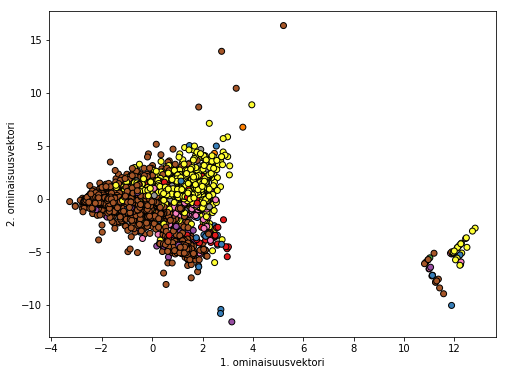

In [72]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=0.7)
x_train_scaled = StandardScaler().fit_transform(X_train)
x_train_pca = pca.fit_transform(x_train_scaled)
print("Muuttujien määrä oli ennen {}, nyt se on {}".format(len(X.columns), len(x_train_pca[0])))

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_train, cmap=plt.cm.Set1,
            edgecolor='k')
ax.set_xlabel('1. ominaisuusvektori')
ax.set_ylabel('2. ominaisuusvektori')
plt.show()

## Luokittelu
Muodosta sitten putki ([`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline)), johon liität StandardScaler ja PCA esikäsittelyvaiheet, käytä PCA:n `n_components`-parametrina arvoa 0.7. Lisää putken viimeiseksi komponentiksi haluamasi luokittelija nimelle "clf".

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

pipe = Pipeline([('scaler', StandardScaler()), ('pca',PCA(n_components=0.7)), ('clf',SVC())])

Suorita sitten hyperparametrioptimointi. Putkitusta käytettäessä laita parametrisanakirjaan luokittelijakomponentin nimi ja kaksi alaviivaa ennen parametrin nimeä. Esimerkiksi SVM-algoritmin `C`-parametrin tapauksessa:
```python
params_without_pipeline = {'C':[1,10]}
params_with_pipeline = {'clf__C':[1,10]}

```

In [91]:
from sklearn.model_selection import GridSearchCV
def train(pipe, parameters):
    clf = GridSearchCV(pipe, parameters, cv=2, n_jobs=-1)
    clf.fit(X_train, y_train)
    print("Parhaat parametrit: ", clf.best_params_)
    print("Paras opetus OA: {:.4f}".format(clf.best_score_))
    print("OA: {:.4f}".format(clf.score(X_test, y_test)))
    return clf

In [79]:
clf = train(pipe, {'clf__C':[1], 'clf__gamma':[1]})
y_pred = clf.predict(X_test)

### Evaluointi

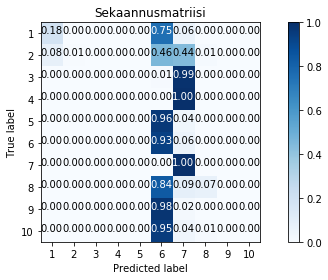

In [81]:
# Evaluoi
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, list(range(1,11)), list(range(1,11)), normalize=True)

## Epätasapainon korjaamista

In [83]:
from collections import Counter, OrderedDict
distribution = dict(OrderedDict(sorted(Counter(y_train).items(), key=lambda t: t[0])))
print(distribution)
thresh = 100
sampling_strategy = {c: val if val <= thresh else thresh for c,val in distribution.items() } 
print(sampling_strategy)

{1.0: 125, 2.0: 122, 3.0: 44, 4.0: 324, 5.0: 139, 6.0: 6908, 7.0: 10789, 8.0: 316, 9.0: 155, 10.0: 162}
{1.0: 100, 2.0: 100, 3.0: 44, 4.0: 100, 5.0: 100, 6.0: 100, 7.0: 100, 8.0: 100, 9.0: 100, 10.0: 100}


Parhaat parametrit:  {'clf__C': 1, 'clf__gamma': 1}
Paras opetus OA: 0.3928
OA: 0.3756


/home/joona/IdeaProjects/MLCourse/venv/forNb/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


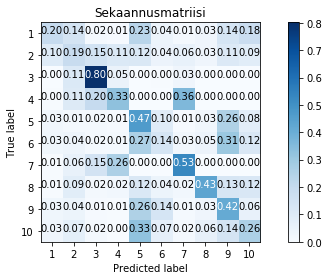

In [92]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as Pipeline_imb

pipe_imb = Pipeline_imb([('scaler', StandardScaler()), ('pca',PCA(n_components=0.7)), 
                         ('rus', RandomUnderSampler('not minority')),
                         ('clf',SVC())])
clf = train(pipe_imb, {'clf__C':[1], 'clf__gamma':[1]})
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, list(range(1,11)), list(range(1,11)), normalize=True)